In [71]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.ndimage.measurements import center_of_mass
from tqdm import tqdm_notebook as tqdm
import h5py

In [2]:
"""
Extract images from npy files
"""
train_x = np.load('train_images.npy', encoding='latin1')
train_x = np.array([arr[1] for arr in train_x], np.uint8)
train_x = np.array([train_x[idx].reshape(100, 100) for idx in range(len(train_x))], np.uint8)
train_y = np.array(pd.read_csv('train_labels.csv', usecols=['Category']))

test_x = np.load('test_images.npy', encoding='latin1')
test_x = np.array([arr[1] for arr in test_x], np.uint8)
test_x = np.array([test_x[idx].reshape(100, 100) for idx in range(len(test_x))], np.uint8)

In [4]:
def find_contours(img_gray):
    """
    Finding contours for the
    given greyscale image

    @param
        :type np.array img_gray - greyscale version of the image

    @return
        :rtype np.array - the image
        :rtype np.array - contours found for the image

    """
    ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
    thresh = thresh.astype('uint8')
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return image, contours

In [5]:
def clean_noise_by_contours(image, contours):
    """
    Cleaning out the noise from the
    image based on the contours found
    using find_contours(img_gray)

    @param
        :type np.array image - image to clean
        :type np.arary contours - contours found for the image

    @return
        :rtpe np.array - cleaned version of the image
        
    """
    num_contour = len(contours)
    
    max_area = 0
    max_area_idx = 0
    for i in range(0, num_contour):
        contour = contours[i]
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_area_idx = i
    
    for i in range(0, num_contour):
        if i != max_area_idx:
            cv2.drawContours(image, contours, i, -1, 3)
            
    plt.imshow(image)
    return image

In [6]:
def cropImage(cleaned_img):
    """
    Crop the cleaned image to
    return just the drawing
    in a smaller square of side 30.

    @param
        :type np.array cleaned_img - cleaned image

    @return
        :rtype np.array - cropped version of the cleaned image
    """
    sq_side_length = 30
    sq_half_side = int(sq_side_length/2)
    center_h, center_w = center_of_mass(cleaned_img)
    center_h = int(center_h)
    center_w = int(center_w)
    top_h = center_h - sq_half_side
    bottom_h = center_h + sq_half_side
    left_w = center_w - sq_half_side
    right_w = center_w + sq_half_side
    
    new_val_bound = check_within_bounds(top_h)
    top_h = new_val_bound[0]
    bottom_h += new_val_bound[1]
    
    new_val_bound = check_within_bounds(bottom_h)
    bottom_h = new_val_bound[0]
    top_h -= new_val_bound[1]
    
    new_val_bound = check_within_bounds(left_w)
    left_w = new_val_bound[0]
    right_w += new_val_bound[1]
    
    new_val_bound = check_within_bounds(right_w)
    right_w = new_val_bound[0]
    left_w -= new_val_bound[1]
    
    cropped_img = cleaned_img[top_h: bottom_h, left_w: right_w]
    plt.imshow(cropped_img)
    return cropped_img

In [7]:
def check_within_bounds(val_to_check):
    """
    Check if the x or y coordinate is 
    within the 100x100 bounds of the image
    
    @param
        :type int val_to_check - coordinate value
    
    @return
        :rtype int - new value for the coordinate
        :rtype int - magnitude of overflow beyond the boundary
        
    """
    if val_to_check < 0:
        return 0, 0 - val_to_check
    elif val_to_check > 100:
        return 100, val_to_check - 100
    else:
        return val_to_check, 0

In [8]:
def rotate(img, angle):
    """
    Rotates the given image 
    by 'angle' degrees

    @param
        :type np.array img - image to rotate
        :type int angle - angle in degrees to rotate by

    @return
        :rtype np.array - original image rotated by 'angle' degrees
        
    """
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    dst = cv2.warpAffine(img, M, (cols,rows))
    plt.imshow(dst)
    return dst

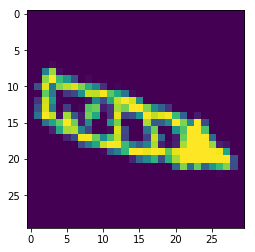

In [10]:
"""
Generating processed images
"""
processed_images = []
rotated_images = []
rotated_labels = []
count = 0
for train_pic in tqdm(train_x):
    image, contours = find_contours(train_pic)
    cleaned_img = clean_noise_by_contours(image, contours)
    cnt = contours[0]
    cropped_img = cropImage(cleaned_img)
    processed_images.append(cropped_img)
    for j in range(1, 6):
        rotated_img = rotate(cropped_img, 60*j)
        rotated_images.append(rotated_img)
    
    rotated_labels += [train_y[count] for k in range(5)]
    count += 1

processed_images += rotated_images
processed_images = np.array(processed_images)
np_rotated_labels = np.array(rotated_labels)
processed_labels = np.concatenate((train_y, np_rotated_labels))

['skull']


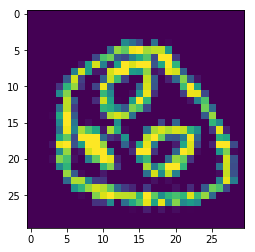

In [72]:
# g = 54284
# print(processed_labels[g])
# plt.imshow(processed_images[g])

In [88]:
"""
Saving the preprocessed images
and the updated labels to new files
"""
# with h5py.File("train_preprocessed.hdf5", "w") as h:
#     dset = h.create_dataset("train_preprocessed", data=processed_images)

# df = pd.DataFrame(processed_labels, columns=['Category'])
# df.to_csv('train_all_labels.csv', index_label='Id')

In [115]:
"""
Read in the saved data
"""
g = h5py.File('train_preprocessed.hdf5', 'r')
train_preprocessed_x = g['train_preprocessed']
train_preprocessed_y = np.array(pd.read_csv('train_all_labels.csv', usecols=['Category']))

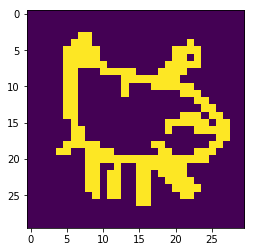

In [120]:
plt.imshow(train_preprocessed_x[3543])

In [ ]:
class image:
    def __init__(self, raw):
        self.raw = raw
        # self.img is a cv2 array
        self.img = self.raw.reshape(100, 100)
        # grayscaled image
        self.grayscaled_img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        # resize grayscaled image
        self.gray = cv2.resize(self.grayscaled_img, (100, 100))
        # grayscaled image after max pooling
        self.resized_img = None
        
    def show(self, img):
        plt.imshow(img)

    def clean_noise(self):
        img = self.gray
        ret, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
        im2, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_NONE)
        self.show(im2)
        return contours
        
                
    # A technique to reduce the dimensions of an image by taking the maximum pixel value of a grid. 
    # This also helps reduce over-fitting and makes the model more generic. 
    def max_pooling(self, side_len):
        slice_x = 100/side_len
        slice_y = slice_x
        res = np.zeros((slice_x, slice_y))
        for i in range(0, slice_x):
            for j in range(0, slice_y):
                max = 0
                for p in range(i*side_len, (i+1)*side_len):
                    for q in range(j*side_len, (j+1)*side_len):
                        val = self.grayscaled_img[p][q]
                        if val>max: 
                            max = val
                res[i][j] = max
        self.resized_img = res
        return res